In [2]:
%run 'Common.ipynb'

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [118]:
from simplejson import JSONDecodeError

def get_cisco_vuln_data(published_date=""):
    response = requests.get(
        f"https://tools.cisco.com/security/center/publicationService.x?cves=&identifiers=&last_published_date={published_date}&limit=20&offset=0&publicationTypeIDs=1,3&resourceIDs=93036&securityImpactRatings=&sort=-last_published&title="
    )
    try:
        return sorted(
            response.json(),
            key=lambda k: k.get('severity', 0)
        )
    except JSONDecodeError:
        return []

In [1]:
from urllib.request import urlopen
from urllib.request import Request
import json
import matplotlib.pyplot as plotter
from prettytable import PrettyTable

x = PrettyTable()
#x.field_names=["identifier","title","version","firstPublished","lastPublished","workflowstatus","id","name","url","severity","workarounds","cwe","cve","ciscoBugId","status","summary","totalcount","realtedResource"]
x.field_names=["Identifer","Severity","Title","ciscoBugId"]
request=urlopen("https://tools.cisco.com/security/center/publicationService.x?cves=&identifiers=&last_published_date=&limit=20&offset=0&publicationTypeIDs=1,3&resourceIDs=93036&securityImpactRatings=&sort=-last_published&title=")
cisco_data = request.read()
data = json.loads(cisco_data)
data = sorted(data, key=lambda k: k.get('severity', 0), reverse=False)
entries=len(data)
count=0
critical=0
high=0
medium=0
while count < entries:
#for identifier,title,version,firstPublished,lastPublished,workflowstatus,id,name,url,severity,workarounds,cwe,cve,ciscoBugId,status,summary,totalcount,realtedResource in data:
    x.add_row([data[count]['identifier'],data[count]['severity'],data[count]['title'],(data[count]['ciscoBugId']).replace(',','\n')])
    if data[count]['severity'] == 'Critical': critical+=1
    if data[count]['severity'] == 'High': high+=1
    if data[count]['severity'] == 'Medium': medium+=1
    count+=1
#print(x)
from IPython.core.display import display, HTML
display(HTML("<h1>Cisco Monthly Vulnerability Feed</h1>"))
display(HTML(x.get_html_string()))

Identifer,Severity,Title,ciscoBugId
cisco-sa-20190828-iosxe-rest-auth-bypass,Critical,Cisco REST API Container for IOS XE Software Authentication Bypass Vulnerability,CSCvn93524CSCvo47376
cisco-sa-20200108-ios-csrf,High,Cisco IOS and Cisco IOS XE Software Web UI Cross-Site Request Forgery Vulnerability,CSCvq66030
cisco-sa-20190925-ftp,High,"Cisco IOS XE Software FTP Application Layer Gateway for NAT, NAT64, and ZBFW Denial of Service Vulnerability",CSCvn02419
cisco-sa-20190925-webui-cmd-injection,High,Cisco IOS XE Software Web UI Command Injection Vulnerabilities,CSCvo61821CSCvp78858CSCvp95724
cisco-sa-20190925-sip-dos,High,Cisco IOS and IOS XE Software Session Initiation Protocol Denial of Service Vulnerability,CSCvn00218
cisco-sa-20190925-sip-alg,High,Cisco IOS XE Software NAT Session Initiation Protocol Application Layer Gateway Denial of Service Vulnerability,CSCvn65912
cisco-sa-20190925-rawtcp-dos,High,Cisco IOS XE Software Raw Socket Transport Denial of Service Vulnerability,CSCvj91021
cisco-sa-20190925-iosxe-fsdos,High,Cisco IOS XE Software Filesystem Exhaustion Denial of Service Vulnerability,CSCvf80363
cisco-sa-20190925-utd,High,Cisco IOS XE Software Unified Threat Defense Denial of Service Vulnerability,CSCvn29244
cisco-sa-20190925-iosxe-digsig-bypass,High,Cisco IOS XE Software Digital Signature Verification Bypass Vulnerability,CSCvj87117CSCvk12460


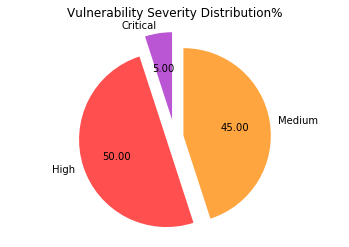

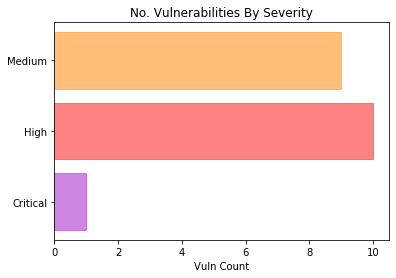

In [3]:
grouped_data = group(data, lambda x: x['severity'])

severities = list(reversed([i[0] for i in cvss_severity_matrix if i[0] in grouped_data]))
severity_counts = [len(grouped_data.get(k,[])) for k in severities]

figureObject, axesObject = plotter.subplots()
pie=axesObject.pie(severity_counts, 
        explode=[explode_severities[k] for k in severities],
        labels=severities,
        autopct='%1.2f',
        colors=[cvss_severity_colors[k] for k in severities],
        startangle=90)
axesObject.axis('equal')
plotter.title('Vulnerability Severity Distribution%')
plotter.show()

figureObject, axesObject = plotter.subplots()
barlist = axesObject.barh(severities,
        severity_counts,
        0.8,
        alpha = 0.7,
        color = 'blue',
        label = 'Vulns')
for i, s in enumerate(severities):
    barlist[i].set_color(cvss_severity_colors[s])
axesObject.set_xlabel('Vuln Count')
plotter.title('No. Vulnerabilities By Severity')
plotter.show()

In [119]:
from concurrent.futures import ThreadPoolExecutor
dates = [d.strftime("%Y+%b") for d in months_backwards(12)]
with ThreadPoolExecutor(max_workers=5) as executor:
    monthly_data = {
        date: group(vuln_data, lambda x: x['severity']) 
        for date, vuln_data in
        executor.map(lambda d: (d, get_cisco_vuln_data(d)), dates)
    }

<function matplotlib.pyplot.show(*args, **kw)>

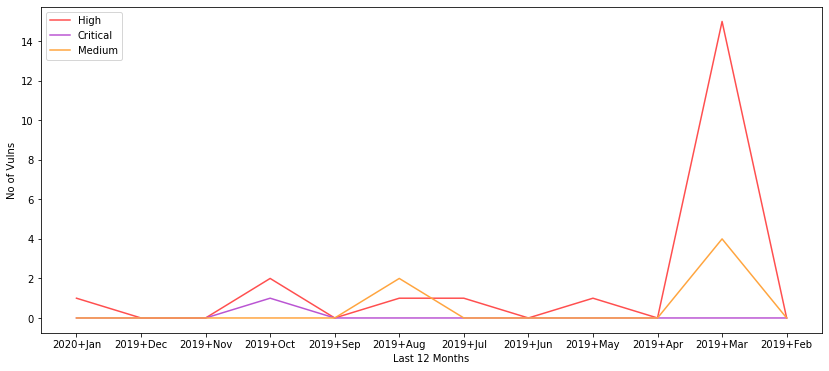

In [122]:
from urllib.request import urlopen
from urllib.request import Request
import matplotlib.pyplot as plt
from datetime  import date, timedelta
from IPython.display import HTML
from itertools import chain
display(HTML("<h2>Cisco Annual Vulnerabilities Tracker</h2>"))

severities = set(chain.from_iterable(v.keys() for k,v in monthly_data.items()))
fig=plt.figure(figsize=(14,6))
ax=fig.add_subplot(111)
for s in severities:
    plt.plot(dates,[len(v[s]) for k, v in monthly_data.items()], color=cvss_severity_colors[s],label=s)
plt.xlabel('Last 12 Months')
plt.ylabel('No of Vulns')
plt.legend(loc=2)
plt.show

